In [427]:
%matplotlib inline

# Лабораторная работа №1, часть 2

In [428]:
from itertools import islice

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as np_rand
import pandas as pd

## Загрузка данных

In [429]:
AREA_COLUMN_NAME = "area"
ROOM_COUNT_COLUMN_NAME = "room_count"
PRICE_COLUMN_NAME = "price"

COLUMN_NAMES = (AREA_COLUMN_NAME, ROOM_COUNT_COLUMN_NAME, PRICE_COLUMN_NAME)

DATA_TYPE = np.float32

data = pd.read_csv(
    "./ex1data2.txt", sep=",", header=None, names=COLUMN_NAMES, dtype=DATA_TYPE
)

FEATURES = data[[AREA_COLUMN_NAME, ROOM_COUNT_COLUMN_NAME]].to_numpy()
TARGET = data[PRICE_COLUMN_NAME]

print(data.head())
print("...")

     area  room_count     price
0  2104.0         3.0  399900.0
1  1600.0         3.0  329900.0
2  2400.0         3.0  369000.0
3  1416.0         2.0  232000.0
4  3000.0         4.0  539900.0
...


## Нормализация признаков
$$
\begin{equation}
x_i := \frac{x_i - \mu_i}{s_i},\\
где \, x_i - признак \, i,\\
\mu_i - среднее \, значение \, признака\\
s_i - среднеквадратичное \, отклонение
\end{equation}
$$

In [430]:
FEATURES_NORMALIZED = (FEATURES - np.mean(FEATURES, axis=0)) / np.std(FEATURES, axis=0)
print(FEATURES_NORMALIZED[:5])
print("...")

[[ 0.13141535 -0.22609334]
 [-0.50964075 -0.22609334]
 [ 0.50790864 -0.22609334]
 [-0.74367714 -1.5543919 ]
 [ 1.2710706   1.1022052 ]]
...


### Коэффициенты для $\theta_0$

In [431]:
FEATURES = np.insert(FEATURES, 0, np.ones(FEATURES.shape[0]), axis=1)
print("Original features:")
print(FEATURES[:5])
print("...")

FEATURES_NORMALIZED = np.insert(FEATURES_NORMALIZED, 0, np.ones(FEATURES_NORMALIZED.shape[0]), axis=1)
print("Normalized features:")
print(FEATURES_NORMALIZED[:5])
print("...")

Original features:
[[1.000e+00 2.104e+03 3.000e+00]
 [1.000e+00 1.600e+03 3.000e+00]
 [1.000e+00 2.400e+03 3.000e+00]
 [1.000e+00 1.416e+03 2.000e+00]
 [1.000e+00 3.000e+03 4.000e+00]]
...
Normalized features:
[[ 1.          0.13141535 -0.22609334]
 [ 1.         -0.50964075 -0.22609334]
 [ 1.          0.50790864 -0.22609334]
 [ 1.         -0.74367714 -1.5543919 ]
 [ 1.          1.2710706   1.1022052 ]]
...


## Функция потерь

$$
\begin{equation*}
\large
J(\theta) = \dfrac {1}{2m} \displaystyle \sum _{i=1}^m \left (h_\theta (x^{(i)}) - y^{(i)} \right)^2, \\
где \, h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dotsc + \theta_n x_n
\end{equation*}
$$

In [432]:

def hypothesis(x_i: np.ndarray, theta: np.ndarray):
    assert theta.shape[0] == x_i.shape[0]

    return sum(x_i_n * t_i for x_i_n, t_i in zip(x_i, theta))


assert hypothesis(np.ones(3), np.ones(3)) == 3


def loss(x: np.ndarray, theta: np.ndarray, y: np.ndarray):
    length = theta.shape[0]
    assert length == x.shape[1]

    return sum(
        (hypothesis(x_i, theta) - y_i) ** 2 for x_i, y_i in zip(x, y)
    ) / DATA_TYPE(length * 2)


%timeit -n 1000 assert 0 == loss(np.eye(3), np.array([1, 2, 3]), np.array([1, 2, 3]))

42.2 µs ± 785 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Реализация с использованием векторизации

In [433]:

def hypothesis_vectorized(x: np.ndarray, theta: np.ndarray):
    assert theta.shape[0] == x.shape[1]

    return np.matmul(x, theta)


assert np.array_equal(hypothesis_vectorized(np.eye(3), np.arange(3)), np.arange(3))


def loss_vectorized(x: np.ndarray, theta: np.ndarray, y: np.ndarray):
    length = theta.shape[0]
    assert length == x.shape[1]

    return np.sum(np.square(hypothesis_vectorized(x, theta) - y)) / DATA_TYPE(
        length * 2
    )


%timeit -n 1000 assert 0 == loss_vectorized(np.eye(3), np.array([1, 2, 3]), np.array([1, 2, 3]))

52.3 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Частные производные функции потерь

$$
\begin{align*}
\frac {\partial}{\partial \theta_n}J(\theta) = \frac{1}{m} \sum\limits_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_n \\
\end{align*}
$$

## Градиентный спуск

$$
\begin{align*}
\theta_n = \theta_n - \alpha\frac {\partial}{\partial \theta_n}J(\theta)
= \theta_n - \alpha\frac{1}{m} \sum\limits_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_n, \\
\end{align*}\\
где \, \alpha - коэффициент \, скорости \, обучения.
$$

In [434]:

def new_params_gen(
    theta: np.ndarray, x: np.ndarray, y: np.ndarray, learning_rate: DATA_TYPE
):
    """Generate new parameters"""
    length = theta.shape[0]
    assert length == x.shape[1]

    coefficient = learning_rate / length
    while True:
        errors = [hypothesis(x_i, theta) - y_i for x_i, y_i in zip(x, y)]
        new_theta = np.fromiter(
            (
                t_n
                - coefficient * sum(error * x_i_n for error, x_i_n in zip(errors, x_i))
                for t_n, x_i in zip(theta, x)
            ),
            dtype=DATA_TYPE,
        )
        yield new_theta
        theta = new_theta


def gradient_descent(theta, x, y, learning_rate, precision=0.0, max_iterations=None):
    iterations = 0
    should_stop = False
    for iterations, new_theta in enumerate(
        islice(new_params_gen(theta, x, y, learning_rate), max_iterations), 1
    ):
        should_stop = all(
            abs(old - new) <= precision for old, new in zip(theta, new_theta)
        )
        theta = new_theta

        if should_stop:
            break

    return theta, iterations

assert check_iter_count == 1
assert np.array_equal(check_theta, np.array([1, 2, 3]))

%timeit -n 1000 next(new_params_gen(np.array([1, 2, 3]), np.eye(3), np.array([1, 2, 3]), 1))

77.5 µs ± 968 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Реализация с использованием векторизации

In [435]:

def new_params_gen_vectorized(
    theta: np.ndarray, x: np.ndarray, y: np.ndarray, learning_rate: DATA_TYPE
):
    length = theta.shape[0]
    assert length == x.shape[1]

    coefficient = learning_rate / length
    while True:
        errors = hypothesis_vectorized(x, theta) - y
        new_theta = theta - coefficient * (np.matmul(np.transpose(x), errors))
        yield new_theta
        theta = new_theta


def gradient_descent_vectorized(
    theta, x, y, learning_rate, precision=0.0, max_iterations=None
):
    iterations = 0
    should_stop = False
    for iterations, new_theta in enumerate(
        islice(new_params_gen_vectorized(theta, x, y, learning_rate), max_iterations)
    ):
        should_stop = np.allclose(theta, new_theta, atol=precision, rtol=0)
        theta = new_theta

        if should_stop:
            break

    return theta, iterations

assert check_iter_count == 1
assert np.array_equal(check_theta, np.array([1, 2, 3]))


%timeit -n 1000 next(new_params_gen_vectorized(np.array([1, 2, 3]), np.eye(3), np.array([1, 2, 3]), 1))

42.7 µs ± 4.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Поиск оптимального значения скорости обучения

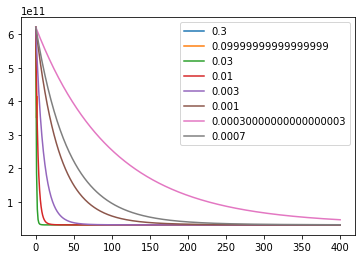

In [443]:

def learning_rate_gen(start=3):
    current_rate = start
    while True:
        yield current_rate
        yield current_rate / 3
        current_rate /= 10


ITERATIONS_LIMIT = 400
THETA_START = np.array([89598.17, 139.2106, -8737.996])
LOSS_START = loss_vectorized(FEATURES_NORMALIZED, THETA_START, TARGET)

def learning_rate_graph(learning_rate):
    loss_values = [LOSS_START]
    for theta in islice(
        new_params_gen_vectorized(THETA_START, FEATURES_NORMALIZED, TARGET, learning_rate),
        ITERATIONS_LIMIT
    ):
        loss_value = loss_vectorized(FEATURES_NORMALIZED, theta, TARGET)
        if loss_value > LOSS_START:
            break
        loss_values.append(loss_value)
    plt.plot(
        list(range(len(loss_values))),
        loss_values,
        label=str(learning_rate)
    )

for learning_rate in islice(learning_rate_gen(0.3), 7):
    learning_rate_graph(learning_rate)

# Оптимальное значение скорости обучения
LEARNING_RATE = DATA_TYPE("0.0007")
learning_rate_graph(LEARNING_RATE)

plt.legend()
plt.show()

## Сравнение производительностей на нормализованных и ненормализованных данных

### Нормализованные признаки

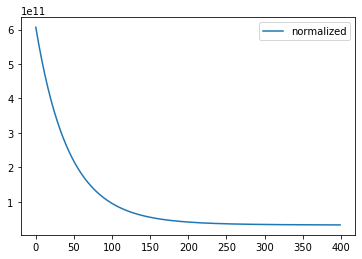

In [437]:
loss_values = []
for iterations, theta in enumerate(
    islice(
        new_params_gen_vectorized(THETA_START, features, TARGET, LEARNING_RATE),
        400
    ),
    1
):
    loss_value = loss_vectorized(features, theta, TARGET)
    if loss_value > LOSS_START:
        break
    loss_values.append(loss_value)
plt.plot(list(range(len(loss_values))), loss_values, label=name)

plt.legend()
plt.show()

### Ненормализованные признаки

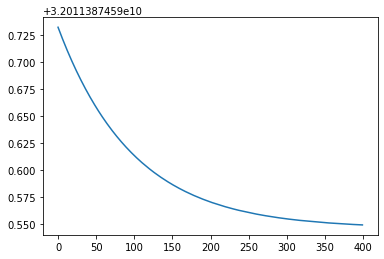

In [438]:
loss_values = []
for iterations, theta in enumerate(
    islice(
        new_params_gen_vectorized(
            THETA_START,
            FEATURES,
            TARGET,
            LEARNING_RATE / 10000000
        ),
        400
    ),
    1
):
    loss_value = loss_vectorized(FEATURES, theta, TARGET)
    loss_values.append(loss_value)
plt.plot(list(range(len(loss_values))), loss_values, label=name)
plt.show()

По графикам видно, что при использовании нормализованных признаков за одинаковое количество шагов функция потерь сходится быстрее. Кроме того использование нормализованных признаков позволяет пользоваться более высоким значением скорости обучения, тогда как более крупные значения скорости обучения без нормализации признаков заставляют функцию вести себя непредсказуемо.

## Решение методом линейной регрессии

In [439]:
LEARNING_RATE = DATA_TYPE("0.0007")

theta_lin_reg, iterations = gradient_descent_vectorized(
    THETA_START, FEATURES_NORMALIZED, TARGET, LEARNING_RATE,
    precision=DATA_TYPE("0.0001"),
    max_iterations=20000
)
print(theta_lin_reg)
print(f"{iterations} iterations; MSE = {loss(FEATURES_NORMALIZED, theta_lin_reg, TARGET)}")

[340412.66785091 109447.77880965  -6578.33543048]
3053 iterations; MSE = 32011387256.3037


## Решение методом наименьших квадратов
$$
\begin{equation}
\large
\theta = (X^{T}X)^{-1}X^{T}y
\end{equation}
$$

In [441]:
features_transposed = np.transpose(FEATURES)
theta_quadr = np.matmul(
    np.matmul(
        np.linalg.inv(
            np.matmul(
                features_transposed,
                FEATURES
            )
        ),
        features_transposed
    ),
    TARGET
)
print("theta from normal equation:")
print(theta_quadr)
print(f"loss: {loss_vectorized(FEATURES, theta_quadr, TARGET)}")

theta from normal equation:
[89598.17     139.2106 -8737.996 ]
loss: 32011386880.0
